In [1]:
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt

In [2]:
#testing parallel run of shorter simulations for Gershman 2012's model, p is the number of simulations to run in parallel

In [2]:
def p_w_new(index,w,x_l,x_r,pi_l,pi_r,beta,var_l,var_r,b,tau,p):
    #index: the index of the weight to be sampled, tuple (i,j)
    #var_1: right mode; var_0: left mode
    i,j = index[0],index[1]
    s_n = w[:,i,j]*x_l[:,i,j]+(1-w[:,i,j])*x_r[:,i,j]
    E_s = (b[:,i,j]-s_n)**2
    w_extended = np.concatenate((w[:,:,0].reshape(p,-1,1),w,w[:,:,-1].reshape(p,-1,1)),axis=2)
    w_extended = np.concatenate((w_extended[:,0,:].reshape(p,1,-1),w_extended,w_extended[:,-1,:].reshape(p,1,-1)),axis=1)
    E_s = E_s + beta*((w_extended[:,i+1,j+1]-w_extended[:,i,j+1])**2+(w_extended[:,i+1,j+1]-w_extended[:,i+1,j])**2)
    E_s = E_s + beta*((w_extended[:,i+1,j+1]-w_extended[:,i+2,j+1])**2+(w_extended[:,i+1,j+1]-w_extended[:,i+1,j+2])**2)
    E_x = 1/(2*var_l)*pi_l[:,i,j]*(x_l[:,i,j]-s_n)**2+1/(2*var_r)*pi_r[:,i,j]*(x_r[:,i,j]-s_n)**2
    return np.exp(-tau*(E_x+E_s))

In [3]:
def p_pi_l_new(index,w,x_l,x_r,pi_l,var_l,b,tau,gamma,p):
    #sparse coefficient alpha TBC
    i,j = index[0],index[1]
    s_n = w[:,i,j]*x_l[:,i,j]+(1-w[:,i,j])*x_r[:,i,j]
    E_xl = 1/(2*var_l)*pi_l[:,i,j]*(x_l[:,i,j]-s_n)**2
    pi_extended = np.concatenate((pi_l[:,:,0].reshape(p,-1,1),pi_l,pi_l[:,:,-1].reshape(p,-1,1)),axis=2)
    pi_extended = np.concatenate((pi_extended[:,0,:].reshape(p,1,-1),pi_extended,pi_extended[:,-1,:].reshape(p,1,-1)),axis=1)
    #E_pi_l = alpha*(pi_extended[i+2,j+1]+pi_extended[i+1,j+2]+pi_extended[i,j+1]+pi_extended[i+1,j])
    '''E_pi_l = E_pi_l + gamma*((pi_extended[:,i+1,j+1]-pi_extended[:,i,j+1])**2+(pi_extended[:i+1,j+1]-pi_extended[:,i+1,j])**2)'''
    E_pi_l = gamma*((pi_extended[:,i+1,j+1]-pi_extended[:,i,j+1])**2+(pi_extended[:,i+1,j+1]-pi_extended[:,i+1,j])**2)
    E_pi_l = E_pi_l + gamma*((pi_extended[:,i+1,j+1]-pi_extended[:,i+2,j+1])**2+(pi_extended[:,i+1,j+1]-pi_extended[:,i+1,j+2])**2)
    return np.exp(-tau*(E_xl+E_pi_l))

In [4]:
def p_pi_r_new(index,w,x_l,x_r,pi_r,var_r,b,tau,gamma,p):
    #sparse coefficient alpha TBC
    i,j = index[0],index[1]
    s_n = w[:,i,j]*x_l[:,i,j]+(1-w[:,i,j])*x_r[:,i,j]
    E_xr = 1/(2*var_r)*pi_r[:,i,j]*(x_r[:,i,j]-s_n)**2
    pi_extended = np.concatenate((pi_r[:,:,0].reshape(p,-1,1),pi_r,pi_r[:,:,-1].reshape(p,-1,1)),axis=2)
    pi_extended = np.concatenate((pi_extended[:,0,:].reshape(p,1,-1),pi_extended,pi_extended[:,-1,:].reshape(p,1,-1)),axis=1)
    #E_pi_l = alpha*(pi_extended[i+2,j+1]+pi_extended[i+1,j+2]+pi_extended[i,j+1]+pi_extended[i+1,j])
    '''E_pi_l = E_pi_l + gamma*((pi_extended[:,i+1,j+1]-pi_extended[:,i,j+1])**2+(pi_extended[:i+1,j+1]-pi_extended[:,i+1,j])**2)'''
    E_pi_r = gamma*((pi_extended[:,i+1,j+1]-pi_extended[:,i,j+1])**2+(pi_extended[:,i+1,j+1]-pi_extended[:,i+1,j])**2)
    E_pi_r = E_pi_r + gamma*((pi_extended[:,i+1,j+1]-pi_extended[:,i+2,j+1])**2+(pi_extended[:,i+1,j+1]-pi_extended[:,i+1,j+2])**2)
    return np.exp(-tau*(E_xr+E_pi_r))

In [5]:
def proposal_function_new(z, index, p, sigma = 1):
    #generate a new proposal from the current sample
    #change only one element at a time!
    z_star = z.copy()
    i,j = index[0],index[1]
    z_star[:,i,j] = z_star[:,i,j] + sigma*random.normal(size = (p))
    return z_star

In [6]:
def binary_proposal_new(z,index):
    #p: the probability of switch, to stablize the system
    z_star = z.copy()
    z_star[:,index[0],index[1]] = 1-z[:,index[0],index[1]]
    return z_star

In [7]:
def sample_rejection_w_new(index,w,w_star,x_l,x_r,pi_l,pi_r,beta,var_l,var_r,b,tau,p):
    p_w_cur = p_w_new(index,w,x_l,x_r,pi_l,pi_r,beta,var_l,var_r,b,tau,p)
    p_w_star = p_w_new(index,w_star,x_l,x_r,pi_l,pi_r,beta,var_l,var_r,b,tau,p)
    p_acc = p_w_star/p_w_cur
    p_ran = random.random(p)
    acc = np.sign(p_acc-p_ran).astype('int')
    return acc
    
def sample_rejection_pi_l_new(index,w,x_l,x_r,pi_l,pi_l_star,var_l,b,tau,gamma,p):
    p_pi_l_cur = p_pi_l_new(index,w,x_l,x_r,pi_l,var_l,b,tau,gamma,p)
    p_pi_l_star = p_pi_l_new(index,w,x_l,x_r,pi_l_star,var_l,b,tau,gamma,p)
    p_acc = p_pi_l_star/p_pi_l_cur
    p_ran = random.random(p)
    acc = np.sign(p_acc-p_ran).astype('int')
    return acc
    
def sample_rejection_pi_r_new(index,w,x_l,x_r,pi_r,pi_r_star,var_r,b,tau,gamma,p):
    p_pi_r_cur = p_pi_r_new(index,w,x_l,x_r,pi_r,var_r,b,tau,gamma,p)
    p_pi_r_star = p_pi_r_new(index,w,x_l,x_r,pi_r_star,var_r,b,tau,gamma,p)
    p_acc = p_pi_r_star/p_pi_r_cur
    p_ran = random.random(p)
    acc = np.sign(p_acc-p_ran).astype('int')
    return acc

In [8]:
def simulation_new(var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample):
    #p: no. parallel sampling sequences
    #no. sample: no. samples in each sequence
    #dim: dimension of each MRF
    sampling_order_i = np.arange(dim)
    sampling_order_j = np.arange(dim)

    #set initial condition for w, pi_r, pi_l
    #set visual input x_r, x_l as conflicting input
    x_l = np.ones((p,dim,dim))
    x_r = np.zeros((p,dim,dim))
    w = random.rand(p,dim,dim)
    pi_l = random.randint(0,2,(p,dim,dim))
    pi_r = random.randint(0,2,(p,dim,dim))

    s = []
    pi_l_l = []
    pi_r_l = []
    for m in range(int(no_sample)):
        #order of sweep is randomnized
        random.shuffle(sampling_order_i)
        random.shuffle(sampling_order_j)
        #the following for loop update on pi_l
        for i in sampling_order_i:
            for j in sampling_order_j:
                index = (i,j)
                pi_r_star = binary_proposal_new(pi_r, index)
                acc_1 = sample_rejection_pi_r_new(index,w,x_l,x_r,pi_r,pi_r_star,var_r,b,tau,gamma,p)
                for j in range(p):
                    if acc_1[j] == 1:
                        pi_r[j,:,:] = pi_r_star[j,:,:]

        #the following for loop update on pi_r
        for i in sampling_order_i:
            for j in sampling_order_j:
                index = (i,j)
                pi_l_star = binary_proposal_new(pi_l, index)
                acc_2 = sample_rejection_pi_l_new(index,w,x_l,x_r,pi_l,pi_l_star,var_l,b,tau,gamma,p)
                for j in range(p):
                    if acc_2[j] == 1:
                        pi_l[j,:,:] = pi_l_star[j,:,:]
    
            #the following for loop update on w
            for i in sampling_order_i:
                for j in sampling_order_j:
                    index = (i,j)
                    w_star = proposal_function_new(w, index, p)
                    acc_3 = sample_rejection_w_new(index,w,w_star,x_l,x_r,pi_l,pi_r,beta,var_l,var_r,b,tau,p)
                    for j in range(p):
                        if acc_3[j] == 1:
                            w[j,:,:] = w_star[j,:,:]
        
        s_i = w*x_l+(1-w)*x_r
        s.append(s_i)
        pi_l_a = pi_l.copy()
        pi_r_a = pi_r.copy()
        pi_l_l.append(pi_l_a)
        pi_r_l.append(pi_r_a)
    return np.array(s),pi_l_l,pi_r_l

In [9]:
#from node's state to the no. node > 0.5 in each step
def node_count(s,p,no_sample):
    state_no_array = []
    for i in range(p):
        state_no_array_i = []
        for j in range(no_sample):
            state_no_array_i.append(len(np.where(s[j,i,:,:]>0.5)[0]))
        state_no_array.append(state_no_array_i)
    state_no_array = np.array(state_no_array)
    return state_no_array

In [10]:
def domi_period_count(state_list_input,dim):
    cross_list = []
    #element in cross list: (index,cross_type)
    #cross type = 1: upper bound going up
    #cross type = 2: lower bound going down
    for i in range(1,len(state_list_input)):
        if state_list_input[i-1]>dim**2*0.1 and state_list_input[i]<dim**2*0.1:
            cross_list.append((i,2))
        elif state_list_input[i-1]<dim**2*0.9 and state_list_input[i]>dim**2*0.9:
            cross_list.append((i,1))
    switch_list = [cross_list[0]]
    cross = cross_list[0][1]
    for i in range(1,len(cross_list)):
        if cross_list[i][1] != cross:
            cross = cross_list[i][1]
            switch_list.append(cross_list[i])
    domi_list =[]
    for i in range(1,len(switch_list)):
        domi_list.append(switch_list[i][0]-switch_list[i-1][0])
    return domi_list

def hist_plot(x,n):
    plt.hist(x,n)
    return np.mean(x),np.std(x)

def generate_domi_list(state_count,dim):
    domi_list = []
    for state_list_i in state_count:
        domi_list_i = domi_period_count(state_list_i,dim)
        domi_list = domi_list + domi_list_i
    return domi_list

In [11]:
def domi_period_count_new(state_list_input,dim):
    cross_list = []
    #element in cross list: (index,cross_type)
    #cross type = 1: upper bound going up
    #cross type = 2: lower bound going down
    for i in range(1,len(state_list_input)):
        if state_list_input[i-1]>0.1*dim**2 and state_list_input[i]<0.1*dim**2:
            cross_list.append((i,2))
        elif state_list_input[i-1]<0.9*dim**2 and state_list_input[i]>0.9*dim**2:
            cross_list.append((i,1))
    switch_list = [cross_list[0]]
    cross = cross_list[0][1]
    for i in range(1,len(cross_list)):
        if cross_list[i][1] != cross:
            cross = cross_list[i][1]
            switch_list.append(cross_list[i])
    domi_list =[]
    percept_list = []
    for i in range(1,len(switch_list)):
        domi_list.append(switch_list[i][0]-switch_list[i-1][0])
        percept_list.append(switch_list[i-1][1])
    return domi_list,percept_list

def generate_domi_percept_list(state_count,dim):
    domi_list = []
    percept_list = []
    for state_list_i in state_count:
        domi_list_i,percept_list_i = domi_period_count_new(state_list_i,dim)
        domi_list = domi_list + domi_list_i
        percept_list = percept_list+percept_list_i
    return domi_list,percept_list

In [12]:
def predomi_count(domi_period,domi_percept):
    domi_1 = 0
    domi_2 = 0
    for i in range(len(domi_period)):
        if domi_percept[i] == 1:
            domi_1 = domi_1 + domi_period[i]
        else:
            domi_2 = domi_2 + domi_period[i]
    return domi_1/np.sum(domi_period),domi_2/np.sum(domi_period)

def ave_domi_count(domi_period,domi_percept):
    domi_1_t = 0
    domi_2_t = 0
    domi_1_count = 0
    domi_2_count = 0
    for i in range(len(domi_period)):
        if int(domi_percept[i]) == 1:
            domi_1_t = domi_1_t + domi_period[i]
            domi_1_count = domi_1_count +1
        else:
            domi_2_t = domi_2_t + domi_period[i]
            domi_2_count = domi_2_count +1
    return domi_1_t/domi_1_count, domi_2_t/domi_2_count

In [13]:
def pi_count(pi_l,pi_r):
    pi_lr_00 = 0
    pi_lr_01 = 0
    pi_lr_10 = 0
    pi_lr_11 = 0
    for i in range(len(pi_l)):
        if pi_l[i]==0 and pi_r[i]==0:
            pi_lr_00 +=1
        if pi_l[i]==0 and pi_r[i]==1:
            pi_lr_01 +=1
        if pi_l[i]==1 and pi_r[i]==0:
            pi_lr_10 +=1
        if pi_l[i]==1 and pi_r[i]==1:
            pi_lr_11 +=1
    return pi_lr_00/len(pi_l),pi_lr_01/len(pi_l),pi_lr_10/len(pi_l),pi_lr_11/len(pi_l)

In [14]:
var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample = 0.005,0.005,10,10,0,1/250,0.5*np.ones((100,5,5)),5,100,2200
s_ori, pi_l_l_ori, pi_r_l_ori = simulation_new(var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample)

In [15]:
print(pi_count(np.array(pi_l_l_ori).reshape(-1),np.array(pi_r_l_ori).reshape(-1)))

(0.4803372727272727, 0.20043545454545456, 0.2000309090909091, 0.11919636363636364)


Text(0.5, 0, 'percept')

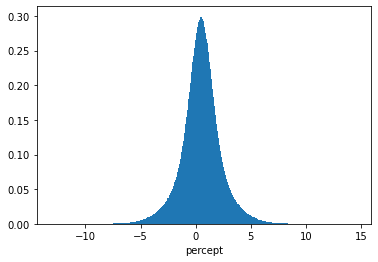

In [17]:
plt.hist(s_ori.reshape(-1),1000,density=True)
plt.xlabel('percept')

In [17]:
var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample = 0.005,0.005,10,10,0,1/100,0.5*np.ones((100,5,5)),5,100,2200
s_00001_00001, pi_l_l_00001_00001, pi_r_l_00001_00001 = simulation_new(var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample)

Text(0, 0.5, 'density')

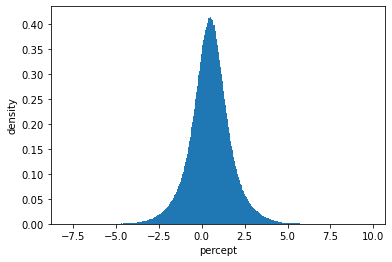

In [18]:
plt.hist(np.array(s_00001_00001).reshape(-1),1000,density=True)
plt.xlabel('percept')
plt.ylabel('density')

In [15]:
var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample = 0.001,0.001,10,10,0,1/100,0.5*np.ones((100,5,5)),5,100,2200
s_0001_0001, pi_l_l_0001_0001, pi_r_l_0001_0001 = simulation_new(var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample)
print('done')

var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample = 0.0025,0.0025,10,10,0,1/100,0.5*np.ones((100,5,5)),5,100,2200
s_00025_00025, pi_l_l_00025_00025, pi_r_l_00025_00025 = simulation_new(var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample)
print('done')

var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample = 0.005,0.005,10,10,0,1/100,0.5*np.ones((100,5,5)),5,100,2200
s_0005_0005, pi_l_l_0005_0005, pi_r_l_0005_0005 = simulation_new(var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample)
print('done')

var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample = 0.0005,0.0005,10,10,0,1/100,0.5*np.ones((100,5,5)),5,100,2200
s_00005_00005, pi_l_l_00005_00005, pi_r_l_00005_00005 = simulation_new(var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample)
print('done')

var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample = 0.00025,0.00025,10,10,0,1/100,0.5*np.ones((100,5,5)),5,100,2200
s_000025_000025, pi_l_l_000025_000025, pi_r_l_000025_000025 = simulation_new(var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample)
print('done')

var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample = 0.0001,0.0001,10,10,0,1/100,0.5*np.ones((100,5,5)),5,100,2200
s_00001_00001, pi_l_l_00001_00001, pi_r_l_00001_00001 = simulation_new(var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample)

done
done
done
done
done


In [16]:
print(pi_count(np.array(pi_l_l_0001_0001).reshape(-1),np.array(pi_r_l_0001_0001).reshape(-1)))
print(pi_count(np.array(pi_l_l_00025_00025).reshape(-1),np.array(pi_r_l_00025_00025).reshape(-1)))
print(pi_count(np.array(pi_l_l_0005_0005).reshape(-1),np.array(pi_r_l_0005_0005).reshape(-1)))
print(pi_count(np.array(pi_l_l_00005_00005).reshape(-1),np.array(pi_r_l_00005_00005).reshape(-1)))
print(pi_count(np.array(pi_l_l_000025_000025).reshape(-1),np.array(pi_r_l_000025_000025).reshape(-1)))
print(pi_count(np.array(pi_l_l_00001_00001).reshape(-1),np.array(pi_r_l_00001_00001).reshape(-1)))

(0.7657363636363637, 0.11435381818181818, 0.1143930909090909, 0.005516727272727273)
(0.6396458181818182, 0.161404, 0.16127054545454544, 0.03767963636363637)
(0.5328069090909091, 0.193876, 0.19352163636363637, 0.07979545454545454)
(0.832554, 0.08351109090909091, 0.08361636363636364, 0.00031854545454545455)
(0.881238, 0.05913545454545455, 0.059625454545454544, 1.090909090909091e-06)
(0.9257656363636364, 0.03713509090909091, 0.03709927272727273, 0.0)


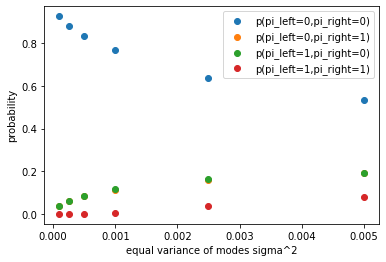

In [17]:
plt.scatter(np.array([0.001,0.0025,0.005,0.0005,0.00025,0.0001]),np.array([0.766,0.639,0.532,0.833,0.881,0.926]))
plt.scatter(np.array([0.001,0.0025,0.005,0.0005,0.00025,0.0001]),np.array([0.1142,0.1612,0.1936,0.08357,0.0595,0.0370]))
plt.scatter(np.array([0.001,0.0025,0.005,0.0005,0.00025,0.0001]),np.array([0.1145,0.1614,0.1939,0.08434,0.0595,0.0370]))
plt.scatter(np.array([0.001,0.0025,0.005,0.0005,0.00025,0.0001]),np.array([0.0055,0.03751,0.08,0.0003,1.4545e-6,0]))
plt.xlabel('equal variance of modes sigma^2')
plt.ylabel('probability')
plt.legend(['p(pi_left=0,pi_right=0)','p(pi_left=0,pi_right=1)','p(pi_left=1,pi_right=0)','p(pi_left=1,pi_right=1)'])

In [18]:
var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample = 0.0025,0.001,10,10,0,1/100,0.5*np.ones((100,5,5)),5,100,2200
s_00025_0001, pi_l_l_00025_0001, pi_r_l_00025_0001 = simulation_new(var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample)

var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample = 0.005,0.001,10,10,0,1/100,0.5*np.ones((100,5,5)),5,100,2200
s_0005_0001, pi_l_l_0005_0001, pi_r_l_0005_0001 = simulation_new(var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample)

var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample = 0.0005,0.001,10,10,0,1/100,0.5*np.ones((100,5,5)),5,100,2200
s_00005_0001, pi_l_l_00005_0001, pi_r_l_00005_0001 = simulation_new(var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample)

var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample = 0.00025,0.001,10,10,0,1/100,0.5*np.ones((100,5,5)),5,100,2200
s_000025_0001, pi_l_l_000025_0001, pi_r_l_000025_0001 = simulation_new(var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample)

var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample = 0.0001,0.001,10,10,0,1/100,0.5*np.ones((100,5,5)),5,100,2200
s_00001_0001, pi_l_l_00001_0001, pi_r_l_00001_0001 = simulation_new(var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample)

In [19]:
print(pi_count(np.array(pi_l_l_0001_0001).reshape(-1),np.array(pi_r_l_0001_0001).reshape(-1)))
print(pi_count(np.array(pi_l_l_00025_0001).reshape(-1),np.array(pi_r_l_00025_0001).reshape(-1)))
print(pi_count(np.array(pi_l_l_0005_0001).reshape(-1),np.array(pi_r_l_0005_0001).reshape(-1)))
print(pi_count(np.array(pi_l_l_00005_0001).reshape(-1),np.array(pi_r_l_00005_0001).reshape(-1)))
print(pi_count(np.array(pi_l_l_000025_0001).reshape(-1),np.array(pi_r_l_000025_0001).reshape(-1)))
print(pi_count(np.array(pi_l_l_00001_0001).reshape(-1),np.array(pi_r_l_00001_0001).reshape(-1)))

(0.7657363636363637, 0.11435381818181818, 0.1143930909090909, 0.005516727272727273)
(0.7008552727272728, 0.105166, 0.17527272727272727, 0.018706)
(0.6382985454545455, 0.09775127272727273, 0.22904563636363637, 0.03490454545454545)
(0.7990649090909091, 0.11878763636363636, 0.08019763636363636, 0.001949818181818182)
(0.8216925454545455, 0.12161636363636363, 0.05591945454545454, 0.0007716363636363637)
(0.8404067272727272, 0.12457381818181819, 0.034731454545454545, 0.000288)


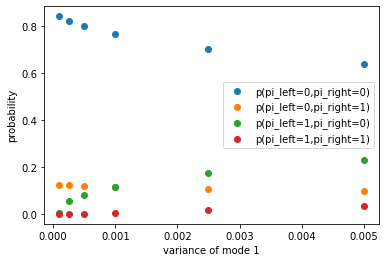

In [20]:
plt.scatter(np.array([0.001,0.0025,0.005,0.0005,0.00025,0.0001]),np.array([0.7658,0.7007,0.6378,0.7988,0.8210,0.8403]))
plt.scatter(np.array([0.001,0.0025,0.005,0.0005,0.00025,0.0001]),np.array([0.1142,0.1054,0.0977,0.1186,0.1223,0.1246]))
plt.scatter(np.array([0.001,0.0025,0.005,0.0005,0.00025,0.0001]),np.array([0.1145,0.175,0.22976,0.0806,0.05594,0.0035]))
plt.scatter(np.array([0.001,0.0025,0.005,0.0005,0.00025,0.0001]),np.array([0.0055,0.019,0.035,0.0019,0.000744,0.0003]))
plt.xlabel('variance of mode 1')
plt.ylabel('probability')
plt.legend(['p(pi_left=0,pi_right=0)','p(pi_left=0,pi_right=1)','p(pi_left=1,pi_right=0)','p(pi_left=1,pi_right=1)'])

0.5170041818181819
0.5219503636363636
0.500284
0.47503
0.4507654545454545
0.42419527272727275


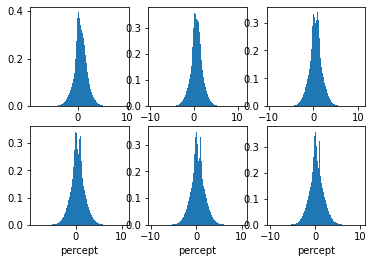

In [21]:
plt.subplot(2,3,1)
plt.hist(np.array(s_0005_0001).reshape(-1),400,density=True)
plt.xlabel('percept')
print(np.sum(np.sign(np.array(s_0005_0001).reshape(-1)-0.5)+1)/len(np.array(s_0005_0001).reshape(-1))/2)

plt.subplot(2,3,2)
plt.hist(np.array(s_00025_0001).reshape(-1),400,density=True)
plt.xlabel('percept')
print(np.sum(np.sign(np.array(s_00025_0001).reshape(-1)-0.5)+1)/len(np.array(s_00025_0001).reshape(-1))/2)

plt.subplot(2,3,3)
plt.hist(np.array(s_0001_0001).reshape(-1),400,density=True)
plt.xlabel('percept')
print(np.sum(np.sign(np.array(s_0001_0001).reshape(-1)-0.5)+1)/len(np.array(s_0001_0001).reshape(-1))/2)


plt.subplot(2,3,4)
plt.hist(np.array(s_00005_0001).reshape(-1),400,density=True)
plt.xlabel('percept')
print(np.sum(np.sign(np.array(s_00005_0001).reshape(-1)-0.5)+1)/len(np.array(s_00005_0001).reshape(-1))/2)

plt.subplot(2,3,5)
plt.hist(np.array(s_000025_0001).reshape(-1),400,density=True)
plt.xlabel('percept')
print(np.sum(np.sign(np.array(s_000025_0001).reshape(-1)-0.5)+1)/len(np.array(s_000025_0001).reshape(-1))/2)

plt.subplot(2,3,6)
plt.hist(np.array(s_00001_0001).reshape(-1),400,density=True)
plt.xlabel('percept')
print(np.sum(np.sign(np.array(s_00001_0001).reshape(-1)-0.5)+1)/len(np.array(s_00001_0001).reshape(-1))/2)

plt.rcParams["figure.figsize"] = (30,15)

(0.9150370454545455, 0.0413475, 0.04121659090909091, 0.0023988636363636365)


Text(0.5, 0, 'percept')

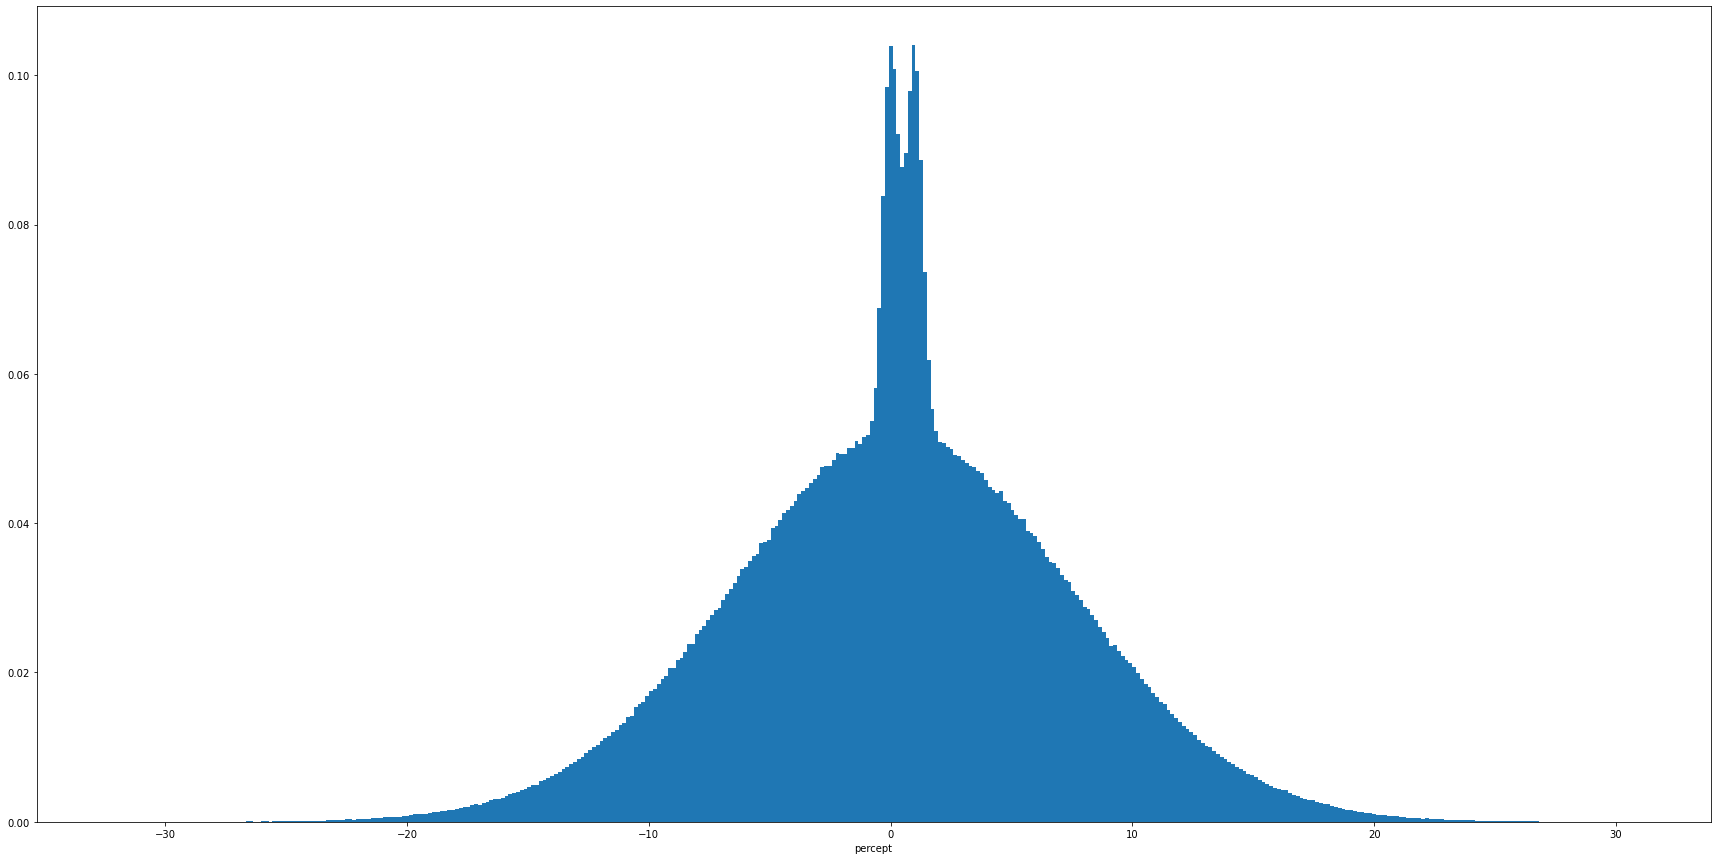

In [22]:
var_0,var_1,beta,gamma,alpha,tau,b,dim,p,no_sample = 0.001,0.001,10,10,0,1/100,0.5*np.ones((1000,1,1)),1,1000,4400
s_0001_0001_1d, pi_l_l_0001_0001_1d, pi_r_l_0001_0001_1d = simulation_new(var_0,var_1,beta,gamma,alpha,tau,b,dim,p,no_sample)
print(pi_count(np.array(pi_l_l_0001_0001_1d).reshape(-1),np.array(pi_r_l_0001_0001_1d).reshape(-1)))
plt.hist(s_0001_0001_1d.reshape(-1),400,density=True)
plt.xlabel('percept')

In [23]:
def mix_gau_1(x):
    return 1/2**0.5/np.pi**0.5*(0.0415175*1/0.1**0.5*np.exp(-1/0.1*x**2/2)+0.0415175*1/0.1**0.5*np.exp(-1/0.1*(x-1)**2/2)+0.9144640909090909*1/50**0.5*np.exp(-1/50*(x-0.5)**2/2))

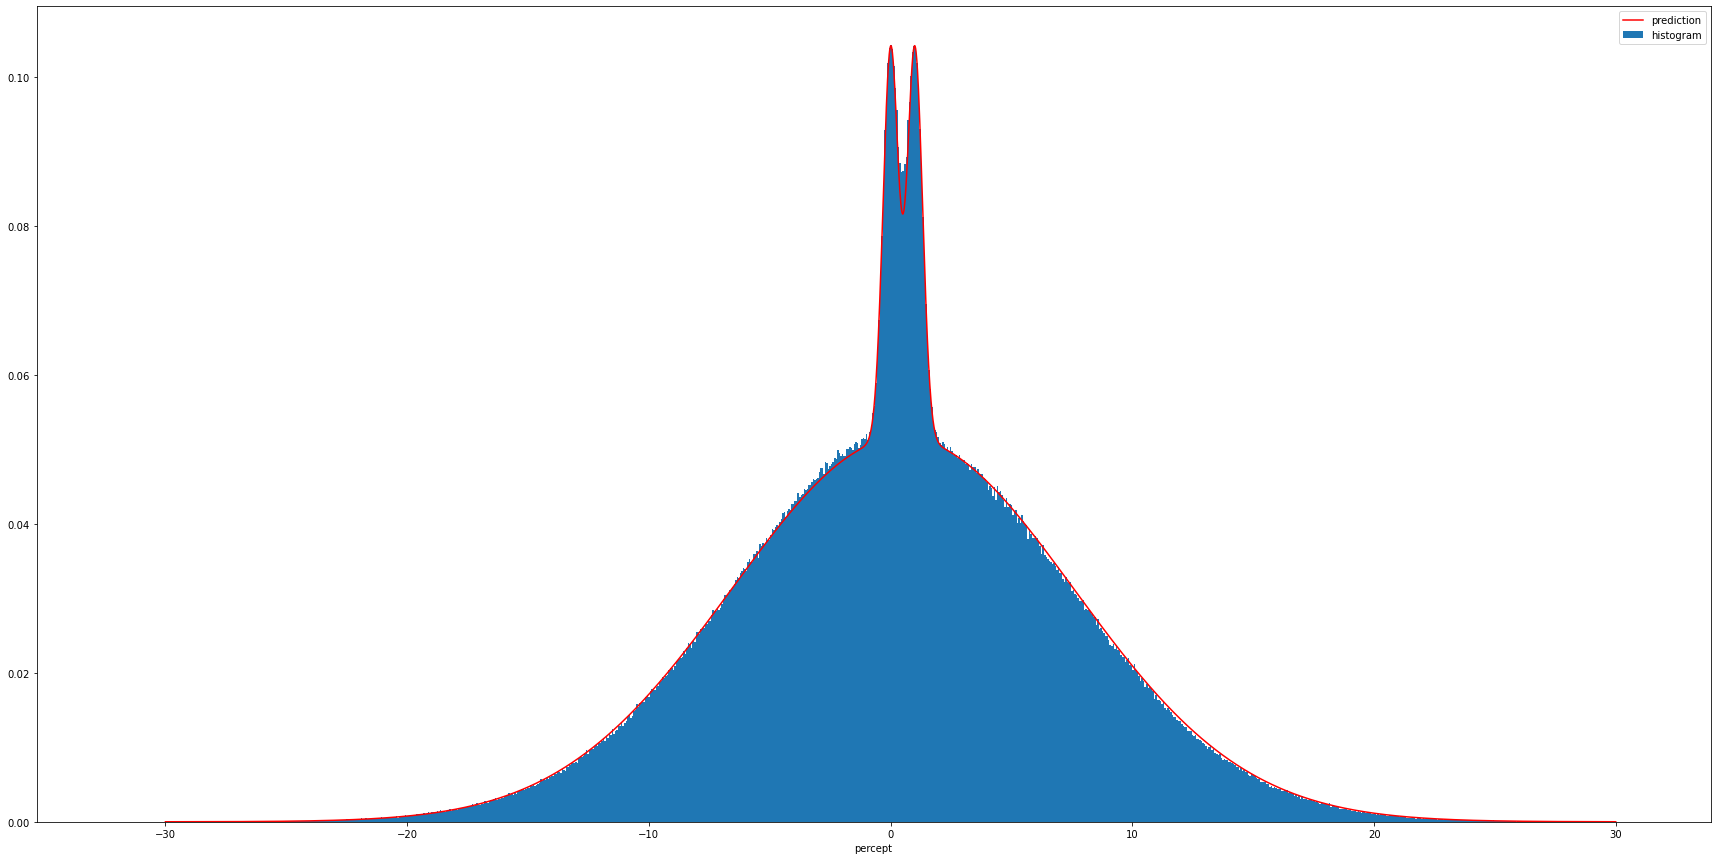

In [24]:
plt.hist(s_0001_0001_1d.reshape(-1),1000,density=True)
x=np.arange(-30,30,0.01)
plt.plot(x,mix_gau_1(x),color='r', linewidth=1.5)
plt.xlabel('percept')
plt.legend(['prediction','histogram'])
plt.rcParams.update({'font.size': 12})